# Summary

In [1]:
<font color='red'><h1>Machine Learning Project - Paolo COSENZA</h1></font>")

# 1. Libraries import and dataset path

In [2]:
%load_ext autoreload   
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import os
import sys
import copy
import logging
import sklearn
from collections import OrderedDict

# for manipulating data
import numpy as np
import pandas as pd
import math
import dill

# for Machine Learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy

# for visualization
from IPython.display import display
from matplotlib import pyplot as plt

In [4]:
# path to repo
path_to_repo = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
path_to_repo

'C:\\Users\\paolo\\Documents\\Emlyon\\01. First period\\09. Advanced machine learning\\main'

In [5]:
sys.path.insert(0, os.path.join(path_to_repo, 'src'))

# custom module
from emlyon.utils import *

In [6]:
# define the path to dataset
path_to_dataset = os.path.join(path_to_repo, 'data' ,'laptop.csv')
print(path_to_dataset)

C:\Users\paolo\Documents\Emlyon\01. First period\09. Advanced machine learning\main\data\laptop.csv


# 2. Presentation of the dataset

The dataset was found on Kaggle at <a href="https://www.kaggle.com/datasets/latoyaclarke/laptop-sales">this</a> address. It contains many different laptop models, with their specifications and the retail price at which the laptops were sold. Other columns include:

- <b>Configuration</b>: a column containing an integer for every laptop configuration, i. e. the mix of different specifications (RAM, hard disk, screen size, ...) that make a laptop unique. It can be seen as a sort of <i>laptop model</i>
- <b>Customer X and customer Y</b>: alongside each laptop there are also two integers that identify two customers that bought the laptop
- <b>Store X and store Y</b>: each row provides two integers to identify the stores where the laptops were sold

In [7]:
df_raw = pd.read_csv(path_to_dataset,
                     low_memory = False)

We are not using the parameter "parsedates" as the <i>Date</i> column still needs to be cleaned and as of now it would not be recognized as a timestamp object.

In [8]:
df_raw.dtypes

Date                       object
Configuration               int64
Customer Postcode          object
Store Postcode             object
Retail Price              float64
Screen Size (Inches)        int64
Battery Life (Hours)        int64
RAM (GB)                    int64
Processor Speeds (GHz)    float64
Integrated Wireless?       object
HD Size (GB)                int64
Bundled Applications?      object
customer X                  int64
customer Y                  int64
store X                   float64
store Y                   float64
dtype: object

In [9]:
df_raw.shape

(297572, 16)

In [10]:
df_raw.head().T

,0,1,2,3,4
Date,01/01/2008 5:47,01/02/2008 1:59,01/02/2008 21:35,01/03/2008 19:44,01/04/2008 15:02
Configuration,1,1,1,1,1
Customer Postcode,E1 6NU,SE26 5QF,SW15 1JN,W1U 2SA,SW3 2DY
Store Postcode,E2 0RY,SE8 3JD,SW18 1NN,NW5 2QH,SW1P 3AU
Retail Price,370.0,370.0,370.0,370.0,370.0
Screen Size (Inches),15,15,15,15,15
Battery Life (Hours),4,4,4,4,4
RAM (GB),1,1,1,1,1
Processor Speeds (GHz),1.5,1.5,1.5,1.5,1.5
Integrated Wireless?,Yes,Yes,Yes,Yes,Yes


# 3. Data cleaning and preprocessing

## 3.1 Variable to predict

We will be predicting the <i>Retail Price</i> variable. As we've seen in class, a great metric to assess the accuracy of a model that predicts prices is the <b>root mean squared error (RMSE)</b>. We'll use this metric for this project as well, alongside with the <i>log</i> of the prices.

In [11]:
df_raw['Retail Price'].describe()

count    284129.000000
mean        508.125936
std         104.611789
min         168.000000
25%         440.000000
50%         500.000000
75%         575.000000
max         890.000000
Name: Retail Price, dtype: float64

In [12]:
df_raw['Retail Price'] = np.log(df_raw['Retail Price'])

In [13]:
df_raw['Retail Price'].describe()

count    284129.000000
mean          6.208971
std           0.211351
min           5.123964
25%           6.086775
50%           6.214608
75%           6.354370
max           6.791221
Name: Retail Price, dtype: float64

## 3.2 Convert date times

In [14]:
df_raw['Date']

0          01/01/2008 5:47
1          01/02/2008 1:59
2         01/02/2008 21:35
3         01/03/2008 19:44
4         01/04/2008 15:02
                ...       
297567     12/29/2008 4:32
297568     12/29/2008 9:31
297569    12/30/2008 10:23
297570    12/30/2008 11:20
297571    12/30/2008 15:19
Name: Date, Length: 297572, dtype: object

We first note that slashes (/) are used to format dates instead of dashes (-). We replace those characters.

In [15]:
df_raw['Date'] = df_raw['Date'].str.replace('/', '-')

The function <i>add_datepart</i> doesn't take into account minutes and seconds, so we'd better remove them from the date. Also, in order to get coherent column names, we duplicate the column 'Date' in 'Date_' and delete the first one.

In [16]:
df_raw['Date_'] = df_raw['Date'].str.slice(stop = -5)

In [17]:
add_datepart(df_raw, 'Date_')

C:\Users\paolo\Documents\Emlyon\01. First period\09. Advanced machine learning\main\src\emlyon\utils.py:161: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())      # puts the name on the df columns


In [18]:
df_raw = df_raw.drop('Date', axis=1)

In [19]:
[df_raw.columns[i] for i in range(len(df_raw.columns)) if df_raw.columns[i].startswith('Date')]

['Date_Year',
 'Date_Month',
 'Date_Week',
 'Date_Day',
 'Date_Dayofweek',
 'Date_Dayofyear',
 'Date_Is_month_end',
 'Date_Is_month_start',
 'Date_Is_quarter_end',
 'Date_Is_quarter_start',
 'Date_Is_year_end',
 'Date_Is_year_start',
 'Date_Elapsed']

In [20]:
len(df_raw.columns)

28

Our dataframe now contains 28 columns.

## 3.3 Convert strings into numbered categories

In [21]:
train_cats(df_raw)

In [22]:
df_raw.dtypes == 'category'

Configuration             False
Customer Postcode          True
Store Postcode             True
Retail Price              False
Screen Size (Inches)      False
Battery Life (Hours)      False
RAM (GB)                  False
Processor Speeds (GHz)    False
Integrated Wireless?       True
HD Size (GB)              False
Bundled Applications?      True
customer X                False
customer Y                False
store X                   False
store Y                   False
Date_Year                 False
Date_Month                False
Date_Week                 False
Date_Day                  False
Date_Dayofweek            False
Date_Dayofyear            False
Date_Is_month_end         False
Date_Is_month_start       False
Date_Is_quarter_end       False
Date_Is_quarter_start     False
Date_Is_year_end          False
Date_Is_year_start        False
Date_Elapsed              False
dtype: bool

In [23]:
df_raw.dtypes[df_raw.dtypes == 'category']

Customer Postcode        category
Store Postcode           category
Integrated Wireless?     category
Bundled Applications?    category
dtype: object

None of these categories presents an inner hierarchy to be respected (like 'Low', 'Medium', 'High'), so we don't need to reorder them.

## 3.4 Inspect missing values

In [24]:
df_raw.isnull().sum().sort_values(ascending = False)/len(df_raw)

Retail Price              0.045176
Date_Year                 0.000702
Date_Dayofyear            0.000702
Date_Dayofweek            0.000702
Date_Day                  0.000702
Date_Week                 0.000702
Date_Month                0.000702
store Y                   0.000497
store X                   0.000497
Date_Is_year_start        0.000000
Date_Is_year_end          0.000000
Date_Is_quarter_start     0.000000
Date_Is_quarter_end       0.000000
Date_Is_month_start       0.000000
Date_Is_month_end         0.000000
Configuration             0.000000
Customer Postcode         0.000000
customer Y                0.000000
customer X                0.000000
Bundled Applications?     0.000000
HD Size (GB)              0.000000
Integrated Wireless?      0.000000
Processor Speeds (GHz)    0.000000
RAM (GB)                  0.000000
Battery Life (Hours)      0.000000
Screen Size (Inches)      0.000000
Store Postcode            0.000000
Date_Elapsed              0.000000
dtype: float64

4.5% of Retail Price values are missing. Since this is our <b>target variable</b>, these rows become useless. Therefore, we drop them from the dataset.

In [25]:
df_raw = df_raw[df_raw['Retail Price'].notnull()]

In [26]:
df_raw['Retail Price'].isnull().sum()/len(df_raw)

0.0

## 3.5 Fully numericalize data

In [27]:
df, y, nas = proc_df(df_raw, 'Retail Price')

In [28]:
df.dtypes

Configuration               int64
Customer Postcode           int16
Store Postcode               int8
Screen Size (Inches)        int64
Battery Life (Hours)        int64
RAM (GB)                    int64
Processor Speeds (GHz)    float64
Integrated Wireless?         int8
HD Size (GB)                int64
Bundled Applications?        int8
customer X                  int64
customer Y                  int64
store X                   float64
store Y                   float64
Date_Year                 float64
Date_Month                float64
Date_Week                 float64
Date_Day                  float64
Date_Dayofweek            float64
Date_Dayofyear            float64
Date_Is_month_end            bool
Date_Is_month_start          bool
Date_Is_quarter_end          bool
Date_Is_quarter_start        bool
Date_Is_year_end             bool
Date_Is_year_start           bool
Date_Elapsed                int64
store X_na                   bool
store Y_na                   bool
Date_Year_na  

In [29]:
y

array([5.91350301, 5.91350301, 5.91350301, ..., 6.3526294 , 6.3526294 ,
       6.70930434])

In [30]:
nas

{'store X': 529902.0,
 'store Y': 179641.0,
 'Date_Year': 2008.0,
 'Date_Month': 9.0,
 'Date_Week': 35.0,
 'Date_Day': 16.0,
 'Date_Dayofweek': 3.0,
 'Date_Dayofyear': 246.0}

## 3.6 Dataset split and score functions

In [31]:
def split_vals(df, n): 
    return df[:n].copy(), df[n:].copy()

In [32]:
n_total = len(df)
n_valid = round(.1*len(df)) 
n_train = n_total - n_valid
n_small = 20000 

print('full number of data points : {}'.format(n_total))
print('number of validation data points : {}'.format(n_valid))
print('number of training data points : {}'.format(n_train))
print('number of subsampled training points : {}'.format(n_small))

full number of data points : 284129
number of validation data points : 28413
number of training data points : 255716
number of subsampled training points : 20000


We decide to keep 10% of the data on the <b>validation set</b> and to leave the remaining 90% of it for the <b>training set</b>.

In [33]:
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small, _ = split_vals(X_train, n_small)
y_small, _ = split_vals(y_train, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of small training data points: X = (20000, 35), y = (20000,)
Number of full training data points: X = (255716, 35), y = (255716,)
Number of validation data points: X = (28413, 35), y = (28413,)


In [34]:
def rmse(y_gold, y_pred):    # y_gold = true values
    return math.sqrt(((y_gold - y_pred)**2).mean())   # y is logged, so we don't need to log() it

In [35]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    print('RMSE on train set: {:.4f}'.format(rmse(m.predict(X_train), y_train)))
    print('RMSE on valid set: {:.4f}'.format(rmse(m.predict(X_valid), y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, y_valid)))
    if hasattr(m, 'oob_score_'): print('R^2 on oob set: {:.4f}'.format(m.oob_score_))  # checks if an object as an attribute
    return                                                                             # for the oob set, more later on

# 4. Regression models

## 4.1 Random Forest Regressor

We begin by using a simple Random Forest Regressor model on the small dataset.

In [36]:
base_model = RandomForestRegressor(n_estimators = 10, 
                                   n_jobs = -1)

%time base_model.fit(X_small, y_small)
print_score(base_model, X_small, y_small, X_valid, y_valid)

CPU times: total: 1.31 s
Wall time: 345 ms
RMSE on train set: 0.0208
RMSE on valid set: 0.5639
R^2 on train set: 0.9877
R^2 on valid set: -10.1195


Terrible results. Let's try the model on the training set.

In [37]:
%time base_model.fit(X_train, y_train)
print_score(base_model, X_train, y_train, X_valid, y_valid)

CPU times: total: 22.2 s
Wall time: 4.45 s
RMSE on train set: 0.0138
RMSE on valid set: 0.1037
R^2 on train set: 0.9953
R^2 on valid set: 0.6240


Results are much better, but the difference between the R2 of the train and validation set is still too enormous. We train the model again by adding the <b>bootstrap</b> feature and the <b>OOB score</b> to see if Training and Validation sets carry big differences.

In [38]:
model = RandomForestRegressor(
    n_estimators = 40, 
    n_jobs = -1, 
    
    bootstrap = True,
    oob_score = True, # default = False
    max_samples = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: total: 5.81 s
Wall time: 1.01 s
RMSE on train set: 0.0178
RMSE on valid set: 0.5632
R^2 on train set: 0.9909
R^2 on valid set: -10.0925
R^2 on oob set: 0.9352


The R2 on the out-of-bag set is very high, while the R2 on the validation set is still terrible. This may be caused by a dishomogeneity on the small training set and the validation set.

Cross validation should allow us to further investigate into this issue.

In [39]:
scores = cross_val_score(model, X_small, y_small, cv = 5, n_jobs = -1)

print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(scores.mean(), scores.std()))

[0.57580889 0.72169987 0.80235523 0.67052776 0.77394153]
r2 is 0.709 with a standard deviation of 0.080


The R2 values calculated on the different folds are not consistent: another proof that the splitting on the dataset led to heavily unbalanced sets. This is why our model is not able to generalize.

## 4.2 Identify source of unbalance in the dataset

We begin by plotting the density curves for each array of the predicted variable.

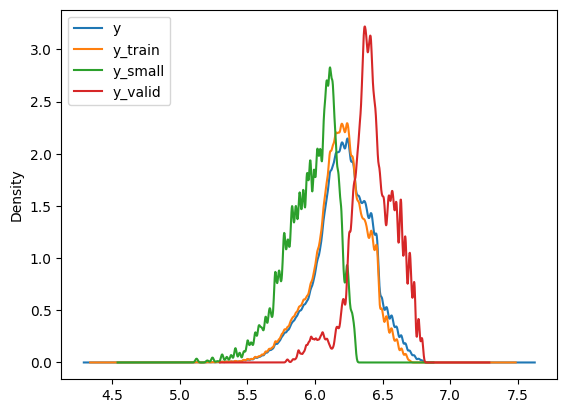

In [40]:
pd.Series(y).plot(kind = 'density', bw_method = 0.05, label='y')
pd.Series(y_train).plot(kind = 'density', bw_method = 0.05, label='y_train')
pd.Series(y_small).plot(kind = 'density', bw_method = 0.05, label='y_small')
pd.Series(y_valid).plot(kind = 'density', bw_method = 0.05, label='y_valid')
plt.legend(loc="upper left")
plt.show()

The curves are very different from one another: whereas y_train follows the line of y, both y_small and y_valid do not represent the actual composition of the dataset and therefore they cannot be used to train a model.

Just for comparison, this is the histogram for the bulldozer dataset used during class:

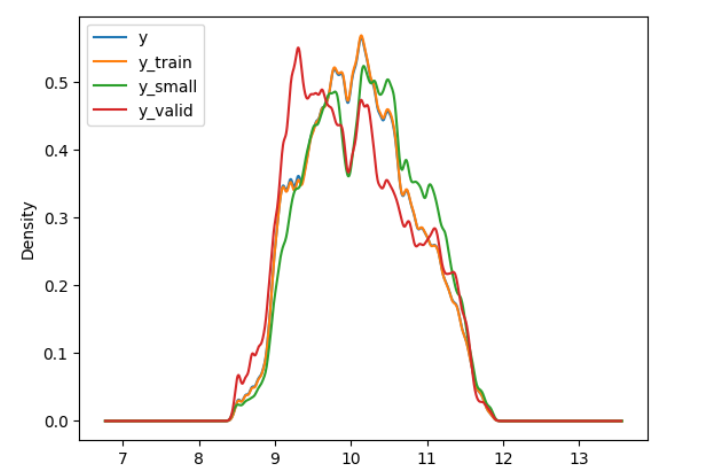

The values in the dataset may be ordered in such a way that generates biases in the dataset - for instance, the vast majority of cheap computers may be gathered on the first half of the dataset.

The best solution I could think of was to <b>randomly resample</b> the whole dataset, in order to make it more homogeneous.

In [41]:
df_raw = df_raw.sample(frac=1).reset_index(drop=True)

In [42]:
df_raw.shape

(284129, 28)

I proceed by processing the dataframe once again.

In [43]:
df, y, nas = proc_df(df_raw, "Retail Price")

In [44]:
n_total = len(df)
n_valid = round(.1*len(df)) 
n_train = n_total - n_valid
n_small = 20000 

print('full number of data points : {}'.format(n_total))
print('number of validation data points : {}'.format(n_valid))
print('number of training data points : {}'.format(n_train))
print('number of subsampled training points : {}'.format(n_small))

full number of data points : 284129
number of validation data points : 28413
number of training data points : 255716
number of subsampled training points : 20000


In [45]:
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small, _ = split_vals(X_train, n_small)
y_small, _ = split_vals(y_train, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of small training data points: X = (20000, 35), y = (20000,)
Number of full training data points: X = (255716, 35), y = (255716,)
Number of validation data points: X = (28413, 35), y = (28413,)


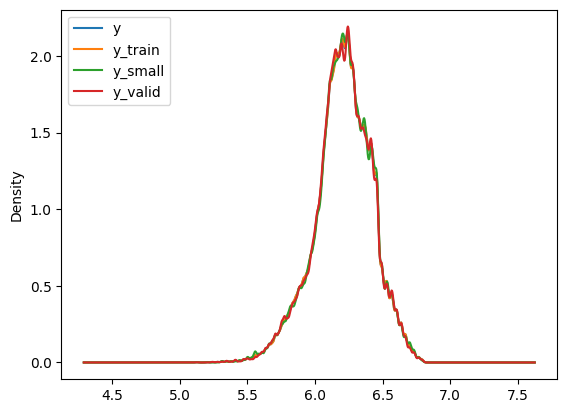

In [46]:
pd.Series(y).plot(kind = 'density', bw_method = 0.05, label='y')
pd.Series(y_train).plot(kind = 'density', bw_method = 0.05, label='y_train')
pd.Series(y_small).plot(kind = 'density', bw_method = 0.05, label='y_small')
pd.Series(y_valid).plot(kind = 'density', bw_method = 0.05, label='y_valid')
plt.legend(loc="upper left")
plt.show()

The curves are now homogeneous.

## 4.3 Modelling on shuffled dataset

In [47]:
model = RandomForestRegressor(
    n_estimators = 40, 
    n_jobs = -1, 
    
    bootstrap = True,
    oob_score = True, # default = False
    max_samples = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: total: 9.14 s
Wall time: 1.37 s
RMSE on train set: 0.0284
RMSE on valid set: 0.0735
R^2 on train set: 0.9819
R^2 on valid set: 0.8776
R^2 on oob set: 0.8717


Finally our model produces some valid results. Most importantly, the <b>OOB score</b> and <b>R^2 score</b> on the valid set are finally close. 

Let's now introduce some <b>stopping criteria</b>, <b>data subsampling</b> and <b>features subsampling</b>.

In [48]:
model = RandomForestRegressor(
    n_estimators = 100, 
    max_features = 0.5,                     # feature subsampling
    n_jobs = -1, 

    max_depth = 20,                         # stopping criteria
    min_samples_split = 2, 
    
    bootstrap = True,
    oob_score = True,
    max_samples = 0.5,                       # data subsampling
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: total: 6.95 s
Wall time: 1.39 s
RMSE on train set: 0.0442
RMSE on valid set: 0.0716
R^2 on train set: 0.9564
R^2 on valid set: 0.8839
R^2 on oob set: 0.8827


## 4.4 Hyperparameter tuning

After experimenting a bit with the model, we get an idea of which parameters affect the model the most. <b>Hyperparameter tuning</b> and <b>cross validation</b> through GridSearchCV allow us to try all the different combinations for this parameters on different areas of the dataset, so to generate the best possible RandomForestRegressor model.

In [49]:
param_grid = [
    {'n_estimators': [40, 100],
     'max_depth': [10, 20, None],
     'min_samples_split': [2, 10],
     'max_features': [0.4, 0.75, 1.],
     'max_samples': [0.4, 0.75, 1.],
    },
]

model = RandomForestRegressor(
    bootstrap = True
)

In [50]:
tuned_model = GridSearchCV(
    estimator = model, 
    param_grid = param_grid, 
    scoring = None, # uses estimator's default score method
    n_jobs = -1, 
    refit = True, # keep a fitted version of the overall best model
    cv = 5, 
    return_train_score = True,
    verbose = 2,
)

In [51]:
tuned_model.fit(X_small, y_small)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'max_depth': [10, 20, None],
                          'max_features': [0.4, 0.75, 1.0],
                          'max_samples': [0.4, 0.75, 1.0],
                          'min_samples_split': [2, 10],
                          'n_estimators': [40, 100]}],
             return_train_score=True, verbose=2)

In [52]:
best_model = tuned_model.best_estimator_
best_model

RandomForestRegressor(max_features=0.4, max_samples=1.0)

In [53]:
print_score(best_model, X_small, y_small, X_valid, y_valid)

RMSE on train set: 0.0248
RMSE on valid set: 0.0655
R^2 on train set: 0.9862
R^2 on valid set: 0.9027


In [54]:
# randomized splitting strategy
cv = KFold(n_splits = 5, shuffle = True)

scores = cross_val_score(best_model, X_small, y_small, cv = cv, n_jobs = -1)

print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(scores.mean(), scores.std()))

[0.88573288 0.88772199 0.89250301 0.89381953 0.90263397]
r2 is 0.892 with a standard deviation of 0.006


Hyperparameter tuning allowed us to get a slight but noticeable improvement on the validation set (around 2%).

## 4.5 Random Forest feature importance

In [55]:
def rf_feat_importance(model, df):
    feat_importance = pd.DataFrame({
        'cols': df.columns, 
        'imp': model.feature_importances_,
    })
    feat_importance = feat_importance.sort_values('imp', ascending = False)
    return feat_importance


def rf_unfolded_feat_importance(model, df):
    feat_importance = pd.DataFrame({
        'cols': df.columns, 
        'imp': model.feature_importances_,
    })
    for i, tree in enumerate(model.estimators_):
        feat_importance['imp_' + str(i)] = tree.feature_importances_
    feat_importance = feat_importance.sort_values('imp', ascending = False)
    return feat_importance


# found at
# https://stackoverflow.com/questions/49170296/scikit-learn-feature-importance-calculation-in-decision-trees
def tree_feature_importance(model, normalize = True):

    left_c = model.tree_.children_left
    right_c = model.tree_.children_right

    impurity = model.tree_.impurity    
    node_samples = model.tree_.weighted_n_node_samples 

    # Initialize the feature importance, those not used remain zero
    feature_importance = np.zeros((model.tree_.n_features,))

    for idx, node in enumerate(model.tree_.feature):
        if node >= 0:
            # Accumulate the feature importance over all the nodes where it's used
            feature_importance[node] += (
                impurity[idx]*node_samples[idx] -
                impurity[left_c[idx]]*node_samples[left_c[idx]] -
                impurity[right_c[idx]]*node_samples[right_c[idx]])

    # Number of samples at the root node
    feature_importance /= node_samples[0]

    if normalize:
        normalizer = feature_importance.sum()
        if normalizer > 0:
            feature_importance /= normalizer

    return feature_importance

Based on the best model created through hyperparameter tuning, we can now visualize which features of the dataset affects the most our predictions.

In [56]:
feat_importance = rf_feat_importance(best_model, X_train)
feat_importance[:20]

,cols,imp
0,Configuration,0.241146
5,RAM (GB),0.215376
8,HD Size (GB),0.120102
3,Screen Size (Inches),0.060585
9,Bundled Applications?,0.045679
6,Processor Speeds (GHz),0.040323
19,Date_Dayofyear,0.035045
26,Date_Elapsed,0.034484
4,Battery Life (Hours),0.034306
2,Store Postcode,0.028867


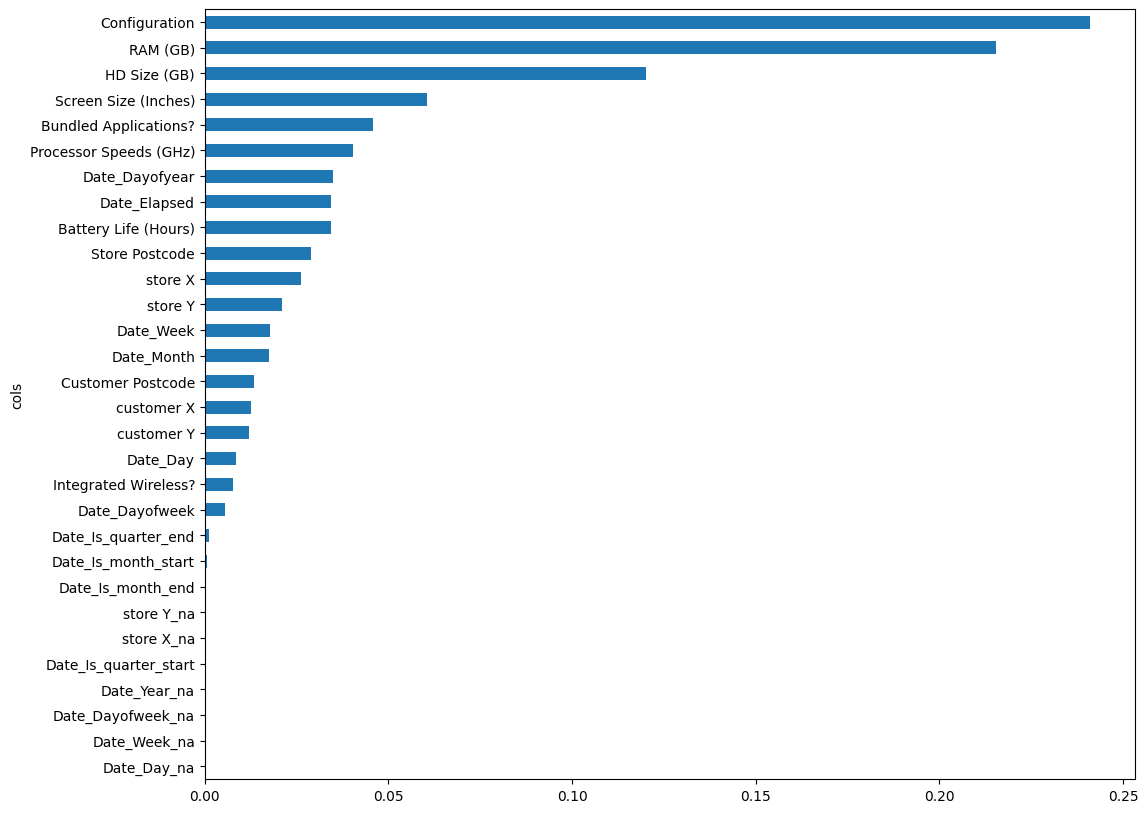

In [57]:
barh = feat_importance[:30].plot('cols', 'imp', 'barh', figsize = (12,10), legend = False)
barh = barh.invert_yaxis()
barh

Since each value of <i>Configuration</i> is based on the laptop specifications, it makes sense for it to be the most important feature to predict <i>Retail Price</i>: configurations that contains larger RAMs, faster processors, bigger hard disks and screens, etc. will lead to more expensive laptops.

Let's see how our model behaves when removing the least important features that could possibly generate <b>noise</b> in our model.

In [58]:
to_keep = feat_importance[feat_importance.imp > 0.005].cols
len(to_keep)

20

In [59]:
# perform ablation of columns with low importance
df_keep = df[to_keep].copy()

n_total = len(df_keep)
n_valid = round(.1*len(df)) 
n_train = n_total - n_valid
n_small = 20000

X_train_keep, X_valid_keep = split_vals(df_keep, n_train)
y_train_keep, y_valid_keep = split_vals(y, n_train)

X_small_keep, _ = split_vals(df_keep, n_small)
y_small_keep, _ = split_vals(y, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small_keep.shape, y_small_keep.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train_keep.shape, y_train_keep.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid_keep.shape, y_valid_keep.shape))

Number of small training data points: X = (20000, 20), y = (20000,)
Number of full training data points: X = (255716, 20), y = (255716,)
Number of validation data points: X = (28413, 20), y = (28413,)


In [60]:
model = RandomForestRegressor(
    n_estimators = 100,
    max_features = 0.4,
    max_depth = 20,
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True,
    max_samples = 1.0
)

%time model.fit(X_small_keep, y_small_keep)
print_score(model, X_small_keep, y_small_keep, X_valid_keep, y_valid_keep)

CPU times: total: 10.5 s
Wall time: 1.75 s
RMSE on train set: 0.0250
RMSE on valid set: 0.0657
R^2 on train set: 0.9861
R^2 on valid set: 0.9022
R^2 on oob set: 0.8989


R2 on validation set does not change. One way to improve it may be through a <b>CatBoostRegressor</b> model.

## 4.6 CatBoostRegressor

In [62]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    n_estimators = 200,
    random_seed = 42,
    loss_function = 'RMSE',
    #allow_writing_files = False,
    logging_level = 'Silent',
)

In [63]:
model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

RMSE on train set: 0.0046
RMSE on valid set: 0.0057
R^2 on train set: 0.9995
R^2 on valid set: 0.9993


Since <b>catboost</b> is much faster than <b>random forest regressor</b>, we can afford to train the model on the full training set. The R2 of this model is extremely high, so we don't see the point to investigate any further regressor models.

# 5. Classification models

While exploring the dataset, I found out that the values of the dependent variable are actually not continuous.

In [64]:
len(np.unique(y))

173

There are only 173 unique retail prices on the dataset. We can try to consider each of this value as a <b>class</b> and apply some classification models on it.

In [65]:
intervals = pd.cut(y, np.unique(y))

In [66]:
intervals[:10].to_list()

[Interval(5.914, 5.916, closed='right'),
 Interval(6.354, 6.363, closed='right'),
 Interval(5.989, 5.991, closed='right'),
 Interval(6.438, 6.446, closed='right'),
 Interval(5.971, 5.979, closed='right'),
 Interval(6.659, 6.666, closed='right'),
 Interval(6.236, 6.244, closed='right'),
 Interval(6.209, 6.215, closed='right'),
 Interval(6.29, 6.292, closed='right'),
 Interval(6.12, 6.131, closed='right')]

In [67]:
y[:10]

array([5.91620206, 6.3630281 , 5.99146455, 6.44571982, 5.97888576,
       6.66568372, 6.2441669 , 6.2146081 , 6.29156914, 6.13122649])

In [68]:
label_encoder = LabelEncoder()

y_cat = label_encoder.fit_transform(intervals)

In [69]:
len(np.unique(y_cat))

173

In [70]:
y_cat_train, y_cat_valid = split_vals(y_cat, n_train)
y_cat_small, _ = split_vals(y_cat, n_small)

y_cat_train.shape, y_cat_valid.shape, y_cat_small.shape

((255716,), (28413,), (20000,))

## 5.1 Decision Tree Classifier

We start by fitting a <b>DecisionTreeClassifier</b> in order to plot one single tree.

In [71]:
tree_classifier = DecisionTreeClassifier(
    class_weight = None, # specific to classifiers
    criterion = 'gini',  # specific to classifiers
    splitter = 'best', 
    max_depth = 3, 
    min_samples_split = 2, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = None, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0,
    random_state = None, 
)

In [72]:
%time tree_classifier.fit(X_small, y_cat_small)

print(tree_classifier.score(X_small, y_cat_small))
print(tree_classifier.score(X_valid, y_cat_valid))

CPU times: total: 0 ns
Wall time: 47 ms
0.05585
0.05145531974800267


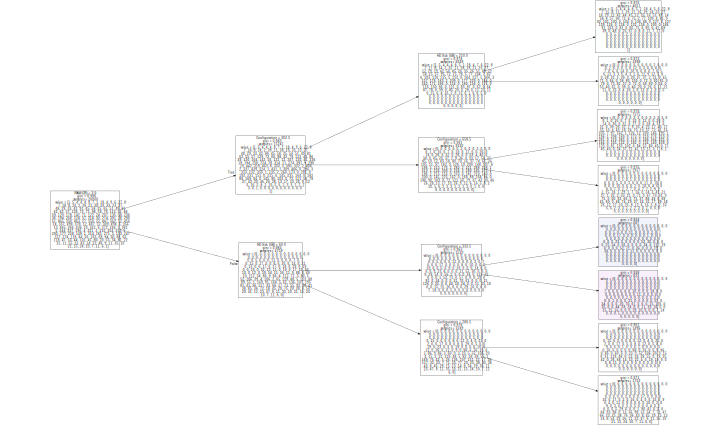

In [73]:
draw_tree(tree_classifier, X_small, precision = 3)

Results are terrible. Maybe we'll get better results with multiple trees.

## 5.2 Random Forest Classifier

In [74]:
classifier = RandomForestClassifier(
    n_estimators = 100, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 20, 
    max_features=0.4,

    bootstrap = True, 
    oob_score = True, 
    max_samples = 1.0,
 
    n_jobs = -1
)

In [75]:
%time classifier.fit(X_small, y_cat_small)

print(classifier.score(X_small, y_cat_small)) # classification accuracy on training set
print(classifier.score(X_valid, y_cat_valid)) # classification accuracy on validation set
print(classifier.oob_score_)                  # classification accuracy on oob samples

CPU times: total: 40.1 s
Wall time: 11.6 s
1.0
0.7083377327279766
0.69115


After experimenting with the parameters and by keeping the results of the hyperparameters tuning as a reference, we obtain almost acceptable results. Let's fit the model with the whole dataset.

In [76]:
%time classifier.fit(X_train, y_cat_train)

print(classifier.score(X_train, y_cat_train)) # classification accuracy on training set
print(classifier.score(X_valid, y_cat_valid)) # classification accuracy on validation set
print(classifier.oob_score_)                    # classification accuracy on oob samples

CPU times: total: 6min 30s
Wall time: 1min 30s
0.9995502823444758
0.9771231478548552
0.9763213877895791


In [77]:
classifier.predict_proba(X_valid[:1])[0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.16883117e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.63636364e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.81818182e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.16883117e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.79220779e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.31548822e-02, 0.00000000e+00,
      

In [78]:
classifier.predict(X_valid[:1])[0]

112

Results are quite remarkable: the model shows levels of accuracy for the validation set only comparable to the <b>Cat Boost Regressor</b> model in predicting 1 class out of 173.

# Conclusions

After experimenting with the dataset through different approaches and techniques, we can assert that the model that produces the best results is the <b>Cat Boost Regressor</b>. However, we would have never reach such results without equalizing the imbalanced data by randomly resample the whole dataset.